# Benchmarking `libjpeg` 📊

This notebook performs a comprehensive benchmark of the `cjpeg` (compress) and `djpeg` (decompress) utilities from the `libjpeg` library.

We will analyze the trade-offs between **compression quality**, **file size**, and **performance** (encoding/decoding speed) across various parameters.

**The process is as follows:**
1.  **Generate** synthetic raw RGB24 images at different resolutions.
2.  **Iterate** through a matrix of `cjpeg` parameters:
    -   Image Resolution: 720p, 1080p, 4K
    -   Quality: 50-100
    -   DCT Method: `int`, `fast`, `float`
    -   Subsampling: `1x1`, `2x1`, `2x2`, and `grayscale`
3.  **Measure** the average encoding and decoding time for each combination over `N` iterations.
4.  **Calculate** image quality metrics (PSNR, SSIM, VMAF) by comparing the original and decompressed images.
5.  **Store** all results in a pandas DataFrame.
6.  **Visualize** the data to draw conclusions about performance and quality.

**Dependencies:**
* `libjpeg` (provides `cjpeg`/`djpeg`)
* `libvmaf` (for VMAF calculation)
* Python libraries: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scikit-image`, `tqdm`

In [1]:
import os
import subprocess
import time
import shutil
import re
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm.notebook import tqdm

# Set plot style
sns.set_theme(style="whitegrid")

In [2]:
# --- Main Configuration ---

# Number of times to run encode/decode for each parameter set to average the time
N_ITERATIONS = 1

# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

# cjpeg parameters to benchmark
QUALITIES = range(50, 101, 5)
DCT_METHODS = ['int', 'fast', 'float']
SUBSAMPLINGS = ['4:4:4', '4:2:2', '4:2:0']

SUBSAMPLING_TO_LIBJPEG = {
    '4:4:4': '1x1',
    '4:2:2': '2x1',
    '4:2:0': '2x2'
}

# --- File and Directory Setup ---
# Create directories to hold our generated files
os.makedirs('raw_images', exist_ok=True)
os.makedirs('temp_files', exist_ok=True)

We download Netflix's 0.6.1 model, which is the default one and [optimized for 1080p HDTV viewing](https://github.com/Netflix/vmaf/blob/master/resource/doc/models.md#predict-quality-on-a-1080p-hdtv-screen-at-3h)

In [3]:
# VMAF model (will be downloaded if not present)
VMAF_MODEL_FILENAME = "vmaf_v0.6.1.json"
VMAF_MODEL_PATH = os.path.join(os.getcwd(), VMAF_MODEL_FILENAME)

In [4]:
def check_dependencies():
    """Checks if required command-line tools are installed."""
    print("🔎 Checking for required command-line tools...")
    tools = ["/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/cjpeg", '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/djpeg', '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libvmaf/bin/vmaf']
    tools = ["/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/cjpeg", '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/djpeg', '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libvmaf/bin/vmaf']
    all_found = True
    for tool in tools:
        if not shutil.which(tool):
            print(f"❌ ERROR: '{tool}' not found in PATH. Please install it.")
            all_found = False
        else:
            print(f"✅ Found '{tool}'")
    if not all_found:
        raise FileNotFoundError("A required command-line tool is missing. Please see the error messages above.")
    print("\nAll dependencies found!")

def download_vmaf_model():
    """Downloads the standard VMAF model if it doesn't exist."""
    if not os.path.exists(VMAF_MODEL_PATH):
        print(f"📥 VMAF model '{VMAF_MODEL_FILENAME}' not found. Downloading...")
        url = f"https://github.com/Netflix/vmaf/raw/master/model/{VMAF_MODEL_FILENAME}"
        try:
            urllib.request.urlretrieve(url, VMAF_MODEL_PATH)
            print("✅ Download complete.")
        except Exception as e:
            print(f"❌ Failed to download VMAF model: {e}")
            raise
    else:
        print(f"✅ VMAF model '{VMAF_MODEL_FILENAME}' already exists.")

check_dependencies()
download_vmaf_model()

🔎 Checking for required command-line tools...
✅ Found '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/cjpeg'
✅ Found '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libjpeg/bin/djpeg'
✅ Found '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libvmaf/bin/vmaf'

All dependencies found!
📥 VMAF model 'vmaf_v0.6.1.json' not found. Downloading...
✅ Download complete.


In [5]:
def generate_ppm_image(width, height, filename):
    """Generates a synthetic P6 PPM image and saves it to a file."""
    if os.path.exists(filename):
        return
    print(f"Generating synthetic PPM image: {filename}...")
    # Create gradients for R, G, B channels
    r = np.linspace(0, 255, width, dtype=np.uint8)
    g = np.linspace(255, 0, width, dtype=np.uint8)
    b = np.linspace(128, 255, height, dtype=np.uint8)

    r_img = np.tile(r, (height, 1))
    g_img = np.tile(g, (height, 1))
    b_img = np.tile(b, (width, 1)).T

    rgb_image_data = np.dstack((r_img, g_img, b_img))

    with open(filename, 'wb') as f:
        header = f"P6\n{width} {height}\n255\n"
        f.write(header.encode('ascii'))
        f.write(rgb_image_data.tobytes())

def read_ppm_p6(filename):
    """Reads a binary P6 PPM file and returns a numpy array."""
    with open(filename, 'rb') as f:
        magic_number = f.readline().strip()
        if magic_number != b'P6':
            raise ValueError("Not a P6 PPM file.")

        line = f.readline()
        while line.startswith(b'#'):
            line = f.readline()

        dims = line.split()
        width, height = int(dims[0]), int(dims[1])

        max_val = int(f.readline().strip())
        if max_val != 255:
            raise ValueError("Only 8-bit PPM files are supported.")

        pixel_data = np.fromfile(f, dtype=np.uint8, count=width*height*3)
        return pixel_data.reshape((height, width, 3))

def calculate_metrics_from_files(original_path, decompressed_path):
    """Calculates PSNR, SSIM, and VMAF by reading two image files."""
    original_img = read_ppm_p6(original_path)
    decompressed_img = read_ppm_p6(decompressed_path)

    # --- PSNR and SSIM ---
    psnr = peak_signal_noise_ratio(original_img, decompressed_img, data_range=255)
    # Explicitly set win_size to avoid error with smaller resolutions
    win_size = min(original_img.shape[0], original_img.shape[1], 7) # Use a small odd number, 7 is typical
    ssim = structural_similarity(original_img, decompressed_img, win_size=win_size, channel_axis=2, data_range=255)

    # --- VMAF ---
    vmaf = 0.0
    #vmaf_cmd = [
    #    '/home/simone/Documenti/video-compression-latency-benchmarks/2_libraries/_installdir/libvmaf/bin/vmaf',
    #    '-q',
    #    '-r', original_path,
    #    '-d', decompressed_path,
    #    '-w', width,
    #    '-h', height,
    #    '-p', subsampling,
    #    '-b', '8'
    #]
    #try:
    #    # Capture stdout and stderr for debugging
    #    result = subprocess.run(vmaf_cmd, check=True, capture_output=True, text=True, timeout=30)
    #    with open(vmaf_log, 'r') as f:
    #        log_content = f.read()
    #    vmaf_match = re.search(r'<vmaf version=".*">(\d+\.\d+)</vmaf>', log_content)
    #    vmaf = float(vmaf_match.group(1)) if vmaf_match else 0.0
    #except subprocess.CalledProcessError as e:
    #    print(f"⚠️ ffmpeg failed with exit code {e.returncode}. stderr:\n{e.stderr}")
    #    print(f"⚠️ Could not calculate VMAF for {os.path.basename(original_path)}: {e}")
    #except Exception as e:
    #    print(f"⚠️ Could not calculate VMAF for {os.path.basename(original_path)}: {e}")
    return psnr, ssim, vmaf

In [6]:
# Create directories to hold our generated files
os.makedirs('raw_images', exist_ok=True)
os.makedirs('temp_files', exist_ok=True)

# Generate the base PPM images for benchmarking
for name, (w, h) in RESOLUTIONS.items():
    ppm_filename = f"raw_images/{name}.ppm"
    generate_ppm_image(w, h, ppm_filename)

print("\n✅ All source PPM images are ready on disk.")

Generating synthetic PPM image: raw_images/1280x720.ppm...
Generating synthetic PPM image: raw_images/1920x1080.ppm...
Generating synthetic PPM image: raw_images/3840x2160.ppm...

✅ All source PPM images are ready on disk.


In [7]:
results = []
total_combinations = len(RESOLUTIONS) * len(QUALITIES) * len(DCT_METHODS) * len(SUBSAMPLINGS)

for res_name, (w, h) in RESOLUTIONS.items():
    original_ppm_path = f"raw_images/{res_name}.ppm"

    # Read the entire source image into memory once per resolution
    with open(original_ppm_path, 'rb') as f:
        original_ppm_data = f.read()

    for quality in QUALITIES:
        for dct in DCT_METHODS:
            for subsample in SUBSAMPLINGS:
                # --- In-Memory Processing ---
                # 1. Benchmark Encoding (cjpeg) in memory
                cjpeg_cmd = ['cjpeg', '-quality', str(quality), '-dct', dct, '-sample', SUBSAMPLING_TO_LIBJPEG[subsample]]
                start_time = time.perf_counter()
                for _ in range(N_ITERATIONS):
                    enc_proc = subprocess.run(cjpeg_cmd, input=original_ppm_data, capture_output=True, check=True)
                end_time = time.perf_counter()
                avg_encode_time = (end_time - start_time) / N_ITERATIONS
                compressed_jpg_data = enc_proc.stdout
                compressed_size = len(compressed_jpg_data)

                # 2. Benchmark Decoding (djpeg) in memory
                djpeg_cmd = ['djpeg', '-ppm']
                start_time = time.perf_counter()
                for _ in range(N_ITERATIONS):
                    dec_proc = subprocess.run(djpeg_cmd, input=compressed_jpg_data, capture_output=True, check=True)
                end_time = time.perf_counter()
                avg_decode_time = (end_time - start_time) / N_ITERATIONS
                decompressed_ppm_data = dec_proc.stdout
                # --- End In-Memory Processing ---

                # --- File-Based Metrics ---
                # 3. Write final decompressed image to a temporary file for analysis
                temp_decompressed_path = f"temp_files/decompressed_output.ppm"
                with open(temp_decompressed_path, 'wb') as f:
                    f.write(decompressed_ppm_data)

                # 4. Calculate Quality Metrics from files
                psnr, ssim, vmaf = calculate_metrics_from_files(original_ppm_path, temp_decompressed_path)

                # 5. Store results
                results.append({
                    'Resolution': res_name, 'Quality': quality, 'DCT': dct, 'Subsampling': subsample,
                    'Iterations': N_ITERATIONS, 'Avg Encode Time (s)': avg_encode_time,
                    'Avg Decode Time (s)': avg_decode_time, 'Compressed Size (KB)': compressed_size / 1024,
                    'PSNR': psnr, 'SSIM': ssim, 'VMAF': vmaf
                })

# Create and save the DataFrame
df = pd.DataFrame(results)
df.to_csv('libjpeg_benchmark_hybrid.csv', index=False)
print("\n✅ Benchmarking complete! Results saved to 'libjpeg_benchmark_hybrid.csv'")
df.head()


✅ Benchmarking complete! Results saved to 'libjpeg_benchmark_hybrid.csv'


,Resolution,Quality,DCT,Subsampling,Iterations,Avg Encode Time (s),Avg Decode Time (s),Compressed Size (KB),PSNR,SSIM,VMAF
0,1280x720,50,int,4:4:4,1,0.014231,0.003598,27.751953,45.890610,0.986530,0.0
1,1280x720,50,int,4:2:2,1,0.003065,0.003458,20.710938,45.237691,0.985469,0.0
2,1280x720,50,int,4:2:0,1,0.002653,0.002533,16.486328,45.013713,0.985323,0.0
3,1280x720,50,fast,4:4:4,1,0.003764,0.003315,27.751953,45.890610,0.986530,0.0
4,1280x720,50,fast,4:2:2,1,0.002994,0.003246,20.710938,45.237691,0.985469,0.0


# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which DCT method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

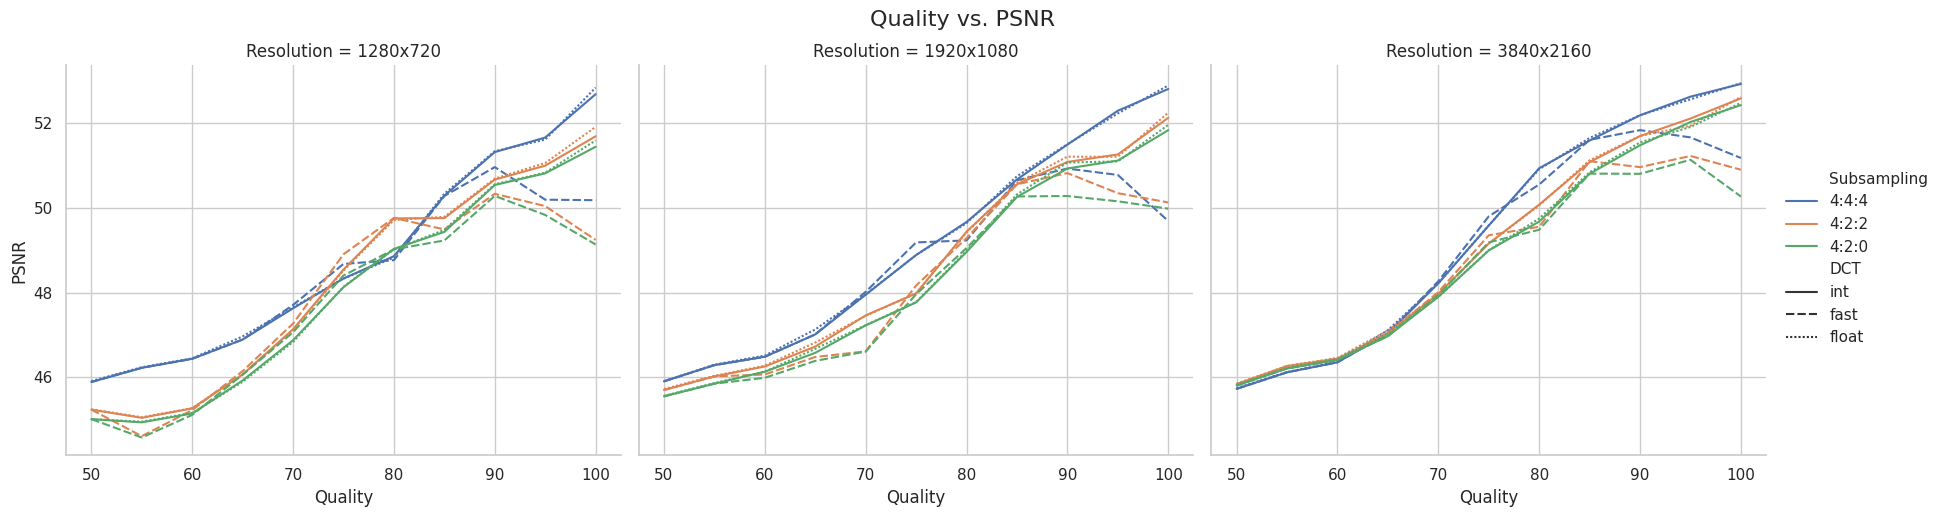

In [8]:
# A good encoder provides high quality (VMAF) for a low file size.
# The "best" curves are in the top-left.

x='Quality'
y='PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    style='DCT',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=['1280x720', '1920x1080', '3840x2160'],
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

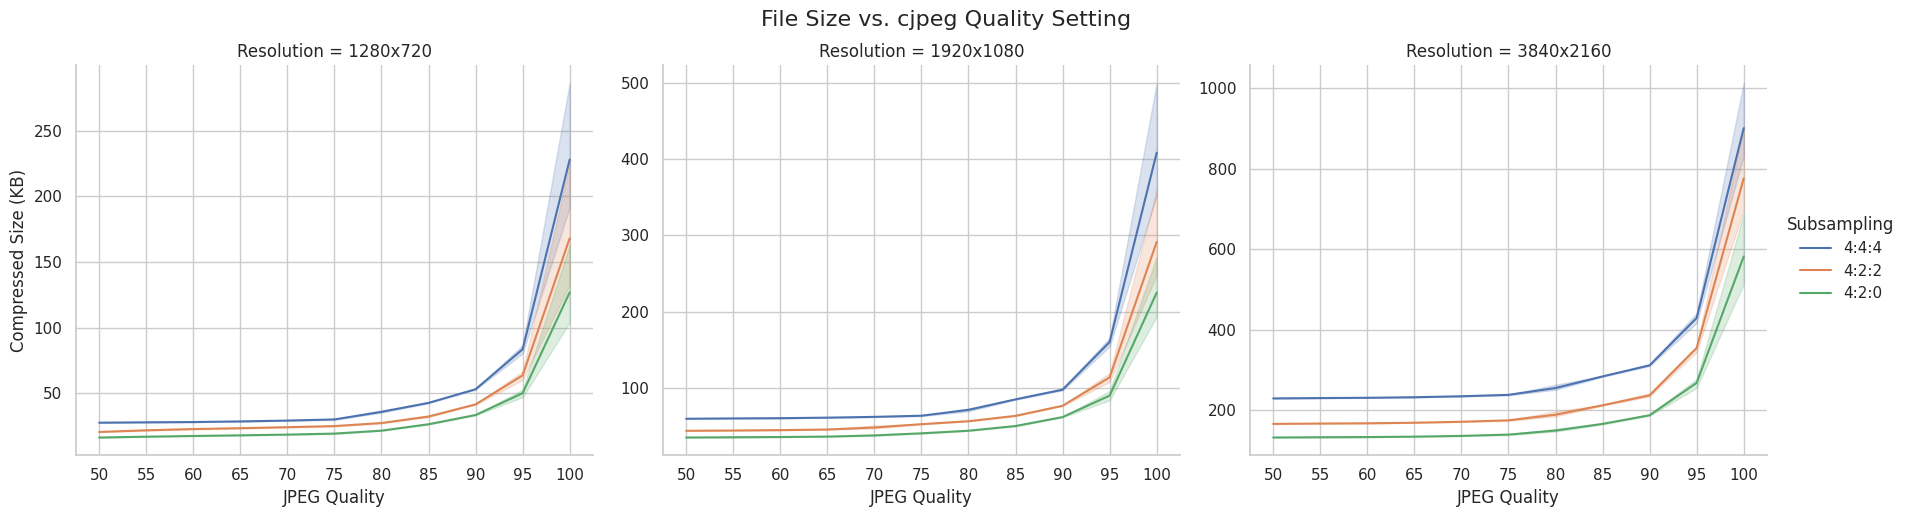

In [9]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=['1280x720', '1920x1080', '3840x2160'],
    facet_kws={'sharey': False}
)

g.figure.suptitle('File Size vs. cjpeg Quality Setting', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
g.set(xticks=QUALITIES)
plt.show()

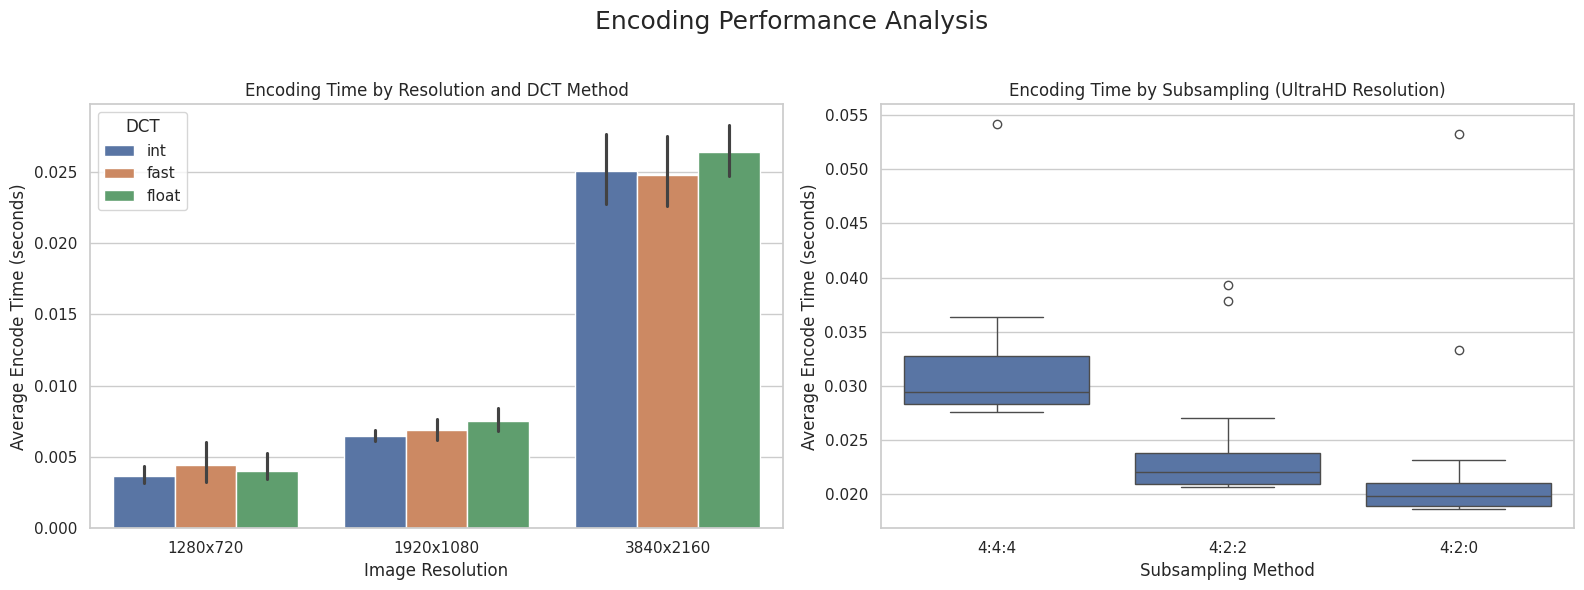

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Encoding Performance Analysis', fontsize=18)

# Plot 1: Encoding time by Resolution and DCT method
sns.barplot(
    data=df,
    x='Resolution',
    y='Avg Encode Time (s)',
    hue='DCT',
    order=['1280x720', '1920x1080', '3840x2160'],
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Resolution and DCT Method')
ax[0].set_ylabel('Average Encode Time (seconds)')
ax[0].set_xlabel('Image Resolution')


# Plot #2: Encoding time by Subsampling method (for UltraHD only)
df_res = df[df['Resolution'] == '3840x2160']
sns.boxplot(
    data=df_res,
    x='Subsampling',
    y='Avg Encode Time (s)',
    order=['4:4:4', '4:2:2', '4:2:0'],
    ax=ax[1]
)
ax[1].set_title('Encoding Time by Subsampling (UltraHD Resolution)')
ax[1].set_ylabel('Average Encode Time (seconds)')
ax[1].set_xlabel('Subsampling Method')


plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

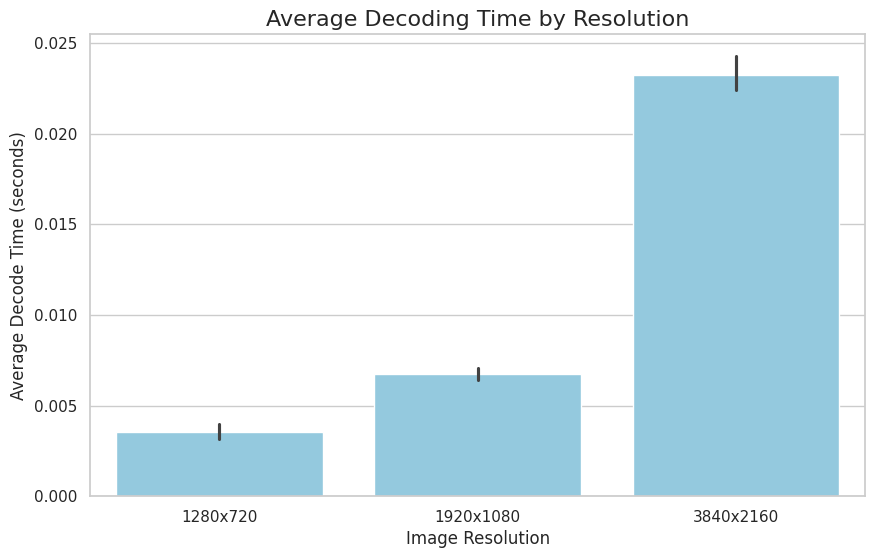

In [11]:
# For decoding, the parameters used for encoding don't matter as much as the resolution.
# We will average the results for each resolution.

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df,
    x='Resolution',
    y='Avg Decode Time (s)',
    order=['1280x720', '1920x1080', '3840x2160'],
    color='skyblue'
)

plt.title('Average Decoding Time by Resolution', fontsize=16)
plt.xlabel('Image Resolution')
plt.ylabel('Average Decode Time (seconds)')
plt.show()

In [12]:
# Clean up the generated directories
try:
    shutil.rmtree('raw_images')
    shutil.rmtree('temp_files')
    os.remove(VMAF_MODEL_PATH)
    os.remove('libjpeg_benchmark_hybrid.csv')
    print("\n🧹 Cleaned up temporary files and directories.")
except OSError as e:
    print(f"Error during cleanup: {e}")


🧹 Cleaned up temporary files and directories.
